# Лабораторная работа №5 
# "Метод сеток для решения волнового уравнения"

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Задание 1

Дано уравнение 
$$
\frac {\partial^2 u}{\partial t^2} = \frac{E}{\rho}\frac {\partial^2 u}{\partial x^2},\ 0\le t \le T,\ 0 \le x\le L 
$$

Со следующими начальными и граничными условиями:
$$
u(0, x) = p(x),\ \frac {\partial u(0, x)}{\partial t} = q(x),\ u(t, 0) = 0,\ u(t, L) = 0
$$

Аппроксимируем вторую производную следующей схемой
$$
\frac {\partial^2 u}{\partial x^2} = \frac {u(x+h) - 2\cdot u(x) + u(x-h)}{h^2}
$$

Формулы для расчетов следующие:

$
u_{j}^0 = p_{j}; 
$

$
u_{j}^1 = u_{j}^0 + \tau \cdot \frac {\partial u_{j}^0}{\partial t} + \frac {\tau^2}{2} \frac {\partial u_{j}^0}{\partial t^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 E}{2\cdot \rho} \frac {\partial^2 u_j}{\partial x^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 E}{2\cdot h_x^2 \rho} (p_{j+1} - 2\cdot p_j + p_{j-1});
$

$
\frac {(u_{j}^{i+1} - 2\cdot u_j^i + u_{j}^{i-1})}{\tau^2} = \frac{E}{\rho} \frac {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)}{h_x^2}
$, отсюда получаем:

$
u_{j}^{i+1} = \frac{\tau^2 E}{\rho h_x^2} {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)} + 2\cdot u_j^i - u_{j}^{i-1};
$

Порядок точности второй и по $h_x$, и по  $\tau$. 

In [41]:
# C = E / rho
def solve(p, q, C, L, N_X, tau, T = None):
    x = np.linspace(0, L, N_X)
    h_x = x[1] - x[0]
    
    n = 0
    solution_prev_prev = np.zeros(N_X)
    solution_prev_prev[1:-1] = p(x[1:-1])
    yield solution_prev_prev
    
    n += 1
    solution_prev = np.zeros(N_X)
    solution_prev[1:-1] = tau * q(x) + p(x[1:-1]) + tau ** 2 * C / (2 * h_x ** 2) * \
                          (p(x[2:]) - 2 * p(x[1:-1]) + p(x[:-2]))
    yield solution_prev
    
    n += 1
    while T is None or n*tau <= T:
        solution = np.zeros(N_X)
        solution[1:-1] = C * ((tau / h_x) ** 2) * (solution_prev[2:] - 2*solution_prev[1:-1] + solution_prev[:-2]) + \
                         2*solution_prev[1:-1] - solution_prev_prev[1:-1]
        yield solution
        
        n += 1
        solution_prev_prev = solution_prev
        solution_prev = solution
        

In [42]:
L = 18
delta_u = 0.2
p = lambda x: -4 * delta_u / (L ** 2) * x ** 2  + 4*delta_u / L * x
q = lambda x: 0
rho = 5.9e5
E = 120e9

x = np.linspace(0, L, 100)
y = list(solve(p, q, E / rho, L, 100, 1e-4, 1e-1))

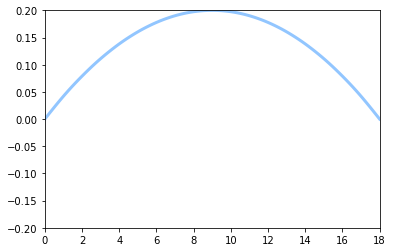

In [44]:
plt.style.use('seaborn-pastel')
fig = plt.figure()
ax = plt.axes(xlim=(0, 18), ylim=(-0.2, 0.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, y[i % len(y)])
    return line,
 
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=800, interval=10, blit=True)
  
anim.save('lab5_task1.mp4', writer='ffmpeg')

## Задание 2

Дано волновое уравнение
$$
\frac {\partial^2 u}{\partial t^2} = (\frac {\partial^2 u}{\partial x^2} + \frac {\partial^2 u}{\partial y^2}),\ 0 \le t \le T,\ -\frac a 2 \le x \le \frac a 2,\ -\frac b 2 \le y \le \frac b 2
$$

Со следующими начальными и граничными условиями:
$
u(0, x, y) = p(x, y),\ \frac {\partial u(0, x, y)}{\partial t} = q(x, y),\ u(t, -\frac a 2 , y) = 0,\ u(t, \frac a 2 , y) = 0,\ \frac {\partial u(t, x, -\frac b 2 )}{\partial y} = 0,\ \frac {\partial u(t, x, \frac b 2 )}{\partial y} = 0
$

Аппроксимируем вторую производную следующей схемой
$
\frac {\partial^2 u}{\partial x^2} = \frac {u(x+h) - 2\cdot u(x) + u(x-h)}{h^2}
$

Формулы для расчетов следующие:

$
u_{j,k}^0 = p_{j,k}; 
$

$
u_{j,k}^1 = u_{j,k}^0 + \tau \cdot \frac {\partial u_{j,k}^0}{\partial t} + \frac {\tau^2}{2} \frac {\partial u_{j,k}^0}{\partial t^2} = p_{j, k} + \tau \cdot q_{j, k} + \frac {\tau^2}{2} (\frac {\partial^2 u_{j,k}}{\partial x^2} + \frac {\partial^2 u_{j,k}}{\partial y^2}) = p_{j, k} + \tau \cdot q_{j, k} + \frac {\tau^2}{2} (\frac {p_{j+1, k} - 2\cdot p_{j, k} + p_{j-1, k}} {h_x^2} + \frac {p_{j, k+1} - 2\cdot p_{j, k} + p_{j, k-1}} {h_y^2});
$

$
\frac {u^{i+1}_{j,k} - 2\cdot u^i_{j,k} + u^{i-1}_{j,k}}{\tau ^2} = \frac{u^{i}_{j+1, k} - 2\cdot u^i_{j,k} + u^{i}_{j-1, k}}{h_x^2} + \frac{u^{i}_{j, k+1} - 2\cdot u^i_{j,k} + u^{i}_{j, k-1}}{h_y^2}
$, отсюда получаем:

$
u^{i+1}_{j,k} = \frac{\tau^2}{h_x^2} (u^{i}_{j+1, k} - 2\cdot u^i_{j,k} + u^{i}_{j-1, k}) + \frac{\tau^2}{h_y^2} (u^{i}_{j, k+1} - 2\cdot u^i_{j,k} + u^{i}_{j, k-1}) + 2\cdot u^i_{j,k} - u^{i-1}_{j,k};
$

$
u_{j,K}^i = u_{j,K-1}^i;
$

$
u_{j,0}^i = u_{j,1}^i;
$

In [31]:
def solve2(a, b, p, q, N_X, N_Y, tau, T = None):
    x = np.array([np.linspace(-a/2, a/2, N_X)]).T
    y = np.array([np.linspace(-b/2, b/2, N_Y)])
    h_x = x[1, 0] - x[0, 0]
    h_y = y[0, 1] - y[0, 0]
    
    n = 0
    solution_prev_prev = np.zeros((N_X, N_Y))
    solution_prev_prev[1:-1, :] = p(x[1:-1], y)
    yield solution_prev_prev.T
    
    n += 1
    solution_prev = np.zeros((N_X, N_Y))
    solution_prev[1:-1, 1:-1] = p(x[1:-1], y[:, 1:-1]) + tau * q(x[1:-1], y[:, 1:-1]) + \
                                (tau / h_x) ** 2 / 2 * (p(x[2:], y[:, 1:-1]) - 2*p(x[1:-1], y[:, 1:-1]) + p(x[:-2], y[:, 1:-1])) + \
                                (tau / h_y) ** 2 / 2 * (p(x[1:-1], y[:, 2:]) - 2*p(x[1:-1], y[:, 1:-1]) + p(x[1:-1], y[:, :-2]))
    solution_prev[1:-1, 0] = solution_prev[1:-1, 1]
    solution_prev[1:-1, -1] = solution_prev[1:-1, -2]
    yield solution_prev.T
    
    n += 1
    while T is None or n*tau <= T:
        solution = np.zeros((N_X, N_Y))
        solution[1:-1, 1:-1] = (tau / h_x) ** 2 * (solution_prev[2:, 1:-1] - 2*solution_prev[1:-1, 1:-1] + solution_prev[:-2, 1:-1]) + \
                               (tau / h_y) ** 2 * (solution_prev[1:-1, 2:] - 2*solution_prev[1:-1, 1:-1] + solution_prev[1:-1, :-2]) + \
                               2*solution_prev[1:-1, 1:-1] - solution_prev_prev[1:-1, 1:-1]
        solution[1:-1, 0] = solution[1:-1, 1]
        solution[1:-1, -1] = solution[1:-1, -2]
        yield solution.T
        
        n += 1
        solution_prev_prev = solution_prev
        solution_prev = solution

In [32]:
a = 2
b = 1
p = lambda x, y: np.arctan(np.cos(np.pi*x/a))
q = lambda x, y: np.sin(2*np.pi*x/a)*np.sin(2*np.pi*y/b)

n_x = 100
n_y = 100

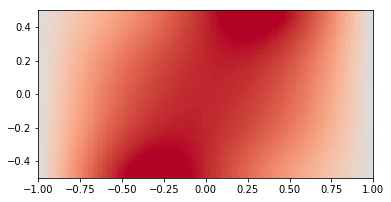

In [34]:
fig = plt.figure()

x = np.linspace(-a/2, a/2, n_x)
y = np.linspace(-b/2, b/2, n_y).reshape(-1, 1)

extent = -a/2, a/2, -b/2, b/2
ims = []
for i in solve2(a, b, p, q, n_x, n_y, 0.001, 4):
    ims.append([plt.imshow(i, animated=True, cmap=plt.cm.coolwarm, vmin=-.84, vmax=.84, extent=extent)])

ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
                                repeat_delay=100)

ani.save("lab5_task2.mp4", writer='ffmpeg')

In [35]:
max_ = 0
min_ = 0
for i in solve2(a, b, p, q, n_x, n_y, 0.001, 4):
    max_ = max(max_, i.max())
    min_ = min(min_, i.min())
print(max_, min_)

0.9174111537747951 -0.8827259061356478
